# Transformers for time-series processing

In this notebook, we continue to play with the Jena Climate dataset [1] presented on the topic of Recurrent Neural Nets. We focus on a single-variable (univariate) time series and pick the temperature reading for building a forecasting model. We start with a recap of the RNN model as a baseline and then proceed to design basic transformer architecture suitable for time-series forecasting. There are usually many hyperparameters one needs to be aware of to unleash its' powers. Thus, the practical tasks would focus on tweaking those parameters and altering the architecture until the results astound you.


__References__
1. Jena Climate Dataset, https://www.kaggle.com/datasets/mnassrib/jena-climate


In [1]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
    assert pl.__version__ == '1.5.10', "old version"
except Exception: # Google Colab does not have PyTorch Lightning
                            # installed by default.
                            # Hence, we do it here if necessary
    !pip install pytorch-lightning==1.5.10
    import pytorch_lightning as pl

     |████████████████████████████████| 527 kB 28.0 MB/s 
     |████████████████████████████████| 952 kB 65.9 MB/s 
     |████████████████████████████████| 136 kB 72.9 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 829 kB 57.6 MB/s 
     |████████████████████████████████| 409 kB 33.7 MB/s 
     |████████████████████████████████| 1.1 MB 65.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 60.2 MB/s 
     |████████████████████████████████| 271 kB 65.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=164402db8b93d947a9bacd1a024db0ba554b25a6fda101af58947a78c9278425
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfu

In [2]:
# Re-loads all imports every time the cell is ran. 
%load_ext autoreload
%autoreload 2

import math
from time import time
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
from IPython.display import display

# Sklearn & stats tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# Neural Networks
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('bmh')
mpl.rcParams['figure.figsize'] = 18, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data


### Load

In [3]:
! wget -nc "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"

--2022-05-17 10:23:19--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  36.7MB/s    in 0.4s    

2022-05-17 10:23:20 (36.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [4]:
data = pd.read_csv("jena_climate_2009_2016.csv.zip")
data = data.iloc[::144] # grab only 144th point (i.e., daily reading)

date_time_key = "Date Time"
data[date_time_key] = pd.to_datetime(data[date_time_key], infer_datetime_format=True)
data.set_index(date_time_key, inplace=True)
data.sort_index(inplace=True)
data.head()


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.520,-8.020,265.400,-8.900,93.300,3.330,3.110,0.220,1.940,3.120,"1,307.750",1.030,1.750,152.300
2009-01-02 00:10:00,989.750,-3.010,270.950,-5.090,85.400,4.890,4.180,0.710,2.630,4.220,"1,274.230",3.630,4.880,26.730
2009-01-03 00:10:00,986.690,5.420,279.650,5.050,97.400,8.990,8.760,0.230,5.540,8.880,"1,229.690",0.800,1.500,177.300
2009-01-04 00:10:00,994.630,3.050,276.640,-0.480,77.500,7.610,5.900,1.710,3.700,5.930,"1,251.620",0.350,0.630,118.500
2009-01-05 00:10:00,992.960,9.660,283.390,8.630,93.300,12.020,11.210,0.810,7.050,11.290,"1,217.850",0.700,1.130,138.800


### Choose a single column

Further studies will be carried out with the temperature column: `T (degC)`.

In [5]:
column_name = "T (degC)"
X = data[[column_name]].values

### Train/test split and preprocessing

In [6]:
N = 6 * len(X) // 7  # approximately 1 year for testing

X_train, X_test = X[:N], X[N:]

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

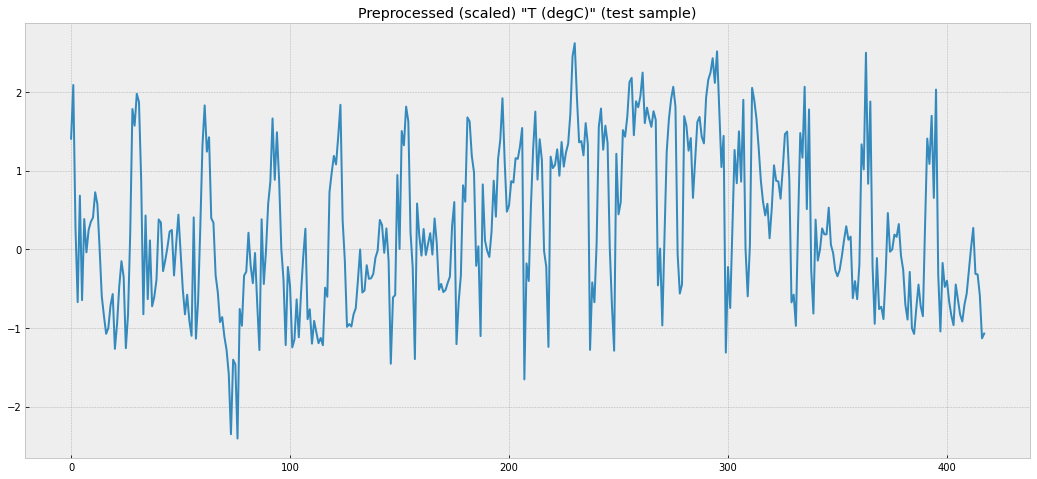

In [7]:
# plt.plot(scaler.inverse_transform(X_test))
plt.plot(X_test)
plt.title(f'Preprocessed (scaled) "{column_name}" (test sample)');

### Preparing to feed the data to PyTorch models

The following function helps translate univariate time series into a tuple of arrays
- series of sequences of the given length
- target values that are shifted by the given number of steps from the beginning of the corresponding sequence

Such tuple is frequently used for building auto-regressive models, thus the function's name.

__Input X shape__: (n)<br>
__Ouput shapes__: ((n - k, k), (n - k))

One can interpret the output as an m-dimensional encoding of each given measurement.  Sometimes it is called a delayed-coordinate representation.

In [8]:
def AR_matrices(X, k, shift=1):
    X_AR = []
    Y_AR = []
    for i in range(k, len(X) - shift + 1):
        ax_ar = X[i - k:i].reshape(-1, )
        X_AR.append(ax_ar)

        ay_ar = X[i + shift - 1]
        Y_AR.append(ay_ar)

    return np.array(X_AR), np.ravel(Y_AR)


temp_X = np.arange(7)
temp_XAR, temp_YAR = AR_matrices(temp_X, 3, 1)
print(temp_XAR, temp_YAR)

[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]] [3 4 5 6]



We define a custom `torch.util.data.Dataset` subclass to transform source time series (`X` and `y`) to PyTorch models such as RNNs and Transformer in sequences of `seq_len` and `target_len` lengths.

In [9]:
class TimeseriesDataset(Dataset):   
    def __init__(self, X: np.ndarray, y: np.ndarray=None, seq_len: int = 1,
                 target_len=1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float() if y is not None else None
        self.seq_len = seq_len
        self.target_len = target_len

    def __len__(self):
        return len(self.X) - self.seq_len + 1

    def __getitem__(self, index):
        if self.y is not None:
            # return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])
            return (self.X[index:index+self.seq_len], 
                    self.y[index:index+self.target_len])  # TODO check if works with LSTM or squeeze it?
        else:
            return self.X[index:index+self.seq_len]

`SequenceDataModule` inherits `pl.LightningDataModule` to provide `Trainer` with properly constructed batches (`batch_size` x `seq_len` x `n_features`).

Details: https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html

In [10]:
class SequenceDataModule(pl.LightningDataModule):
    def __init__(self, X_train, X_test, seq_len=1, n_features=1, batch_size=128, tgt_len=1,
                 num_workers=0, train_size=0.8):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.n_features = n_features
        self.tgt_len = tgt_len

        N = int(train_size * len(X_train))

        self.X_train, self.y_train = AR_matrices(X_train[:N], k=n_features)
        # self.y_train = self.y_train.reshape(-1, 1)
        self.X_val, self.y_val = AR_matrices(X_train[N:], k=n_features)
        # self.y_val = self.y_val.reshape(-1, 1)
        self.X_test, self.y_test = AR_matrices(X_test, k=n_features)
        # self.y_test = self.y_test.reshape(-1, 1)
        # self.columns = None
        self.train_dataset = TimeseriesDataset(self.X_train, self.y_train, 
                                               seq_len=self.seq_len, target_len=tgt_len)
        self.val_dataset = TimeseriesDataset(self.X_val, self.y_val, 
                                             seq_len=self.seq_len, target_len=tgt_len)
        self.test_dataset = TimeseriesDataset(self.X_test, self.y_test,
                                              seq_len=self.seq_len, target_len=tgt_len)
        self.predict_dataset = TimeseriesDataset(self.X_test, 
                                                 seq_len=self.seq_len, target_len=tgt_len)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = False,
                                  num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                                batch_size = self.batch_size, 
                                shuffle = False,
                                num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                                 batch_size = self.batch_size, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, 
                            batch_size = self.batch_size, 
                            shuffle = False, 
                            num_workers = self.num_workers)



```
# Выбран кодовый формат
```

# LSTM model

Resurrect a recurrent neural network to address the forecasting problem.

In [11]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.val_mae = torchmetrics.MeanAbsoluteError()
        self.test_mae = torchmetrics.MeanAbsoluteError()

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, # number of LSTM-layers.
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def training_epoch_end(self, outputs):
        # outputs is a list of dicts
        mean_loss = torch.stack([l['loss'] for l in outputs]).mean()
        self.log('train_loss', mean_loss, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.val_mae.update(y_hat, y)
        return loss

    def validation_epoch_end(self, outputs):
        # outputs is a list of step losses
        self.log('val_loss', torch.mean(torch.stack(outputs)), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.test_mae.update(y_hat, y)
        return loss
    
    def test_epoch_end(self, outputs):
        self.log('test_loss', np.mean(outputs))

In [12]:
lstm_param = dict(
    seq_len = 14,
    batch_size = 96, 
    criterion = nn.MSELoss(),
    max_epochs = 50,
    n_features = 1,
    hidden_size = 100,
    num_layers = 2,
    dropout = 0.1,
    learning_rate = 1e-3)

In [13]:
seed_everything(1)
lstm_model = LSTMRegressor(
    n_features = lstm_param['n_features'],
    hidden_size = lstm_param['hidden_size'],
    seq_len = lstm_param['seq_len'],
    batch_size = lstm_param['batch_size'],
    criterion = lstm_param['criterion'],
    num_layers = lstm_param['num_layers'],
    dropout = lstm_param['dropout'],
    learning_rate = lstm_param['learning_rate'])

Global seed set to 1


In [14]:
class LitProgressBar(pl.callbacks.TQDMProgressBar):
    def init_validation_tqdm(self):
        return tqdm(disable=True)

    def get_metrics(self, trainer, model):
        # don't show the version number
        items = super().get_metrics(trainer, model)
        items.pop("v_num", None)
        return items

if torch.cuda.is_available():
    gpus = 0
else:
    gpus = 0

lstm_trainer = Trainer(
    max_epochs=lstm_param['max_epochs'],
    logger=CSVLogger('./logs', name='lstm', version='0'),
    gpus=gpus,
    log_every_n_steps=20,
    callbacks=[LitProgressBar()]
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


In [15]:
lstm_dm = SequenceDataModule(
    X_train,
    X_test,
    n_features = lstm_param['n_features'],
    seq_len = lstm_param['seq_len'],
    batch_size = lstm_param['batch_size'],)

## Training

In [16]:
lstm_trainer.fit(lstm_model, datamodule=lstm_dm);


  | Name      | Type              | Params
------------------------------------------------
0 | criterion | MSELoss           | 0     
1 | val_mae   | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | lstm      | LSTM              | 122 K 
4 | linear    | Linear            | 101   
------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.488     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

In [17]:
def plot_training_metrics(logger):
    filename = f"{logger.log_dir}/metrics.csv"
    metrics = pd.read_csv(filename)
    train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
    val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
    axes[0].set_title('Train loss per epoch')
    axes[0].plot(train_loss['epoch'], train_loss['train_loss'])
    axes[1].set_title('Validation loss per epoch')
    axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
    plt.show(block = True)

    print('MSE:')
    print(f"\tTrain loss: {train_loss['train_loss'].iloc[-1]:.3f}")
    print(f"\tVal loss:   {val_loss['val_loss'].iloc[-1]:.3f}")

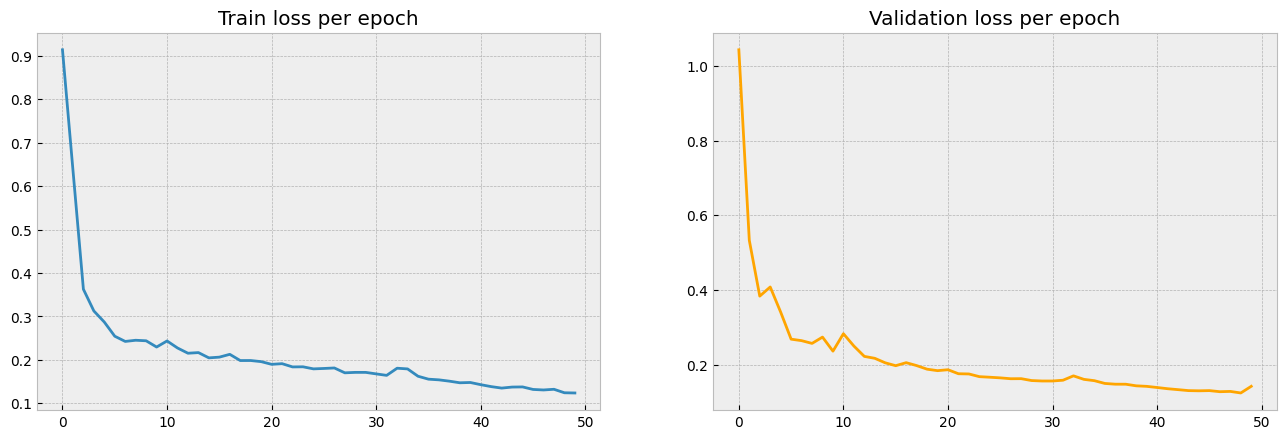

MSE:
	Train loss: 0.124
	Val loss:   0.142


In [18]:
plot_training_metrics(lstm_trainer.logger)

## Testing / Prediction

In [19]:
_, y = map(torch.cat, zip(*lstm_dm.test_dataloader()))
y_hat = torch.cat(lstm_trainer.predict(lstm_model, lstm_dm))

Predicting: 21it [00:00, ?it/s]

In [20]:
def plot_test_predict(y, y_hat, scaler=scaler):
    plt.figure(figsize=(18, 7))
    print(f'MAE loss (sklearn): {mae(y, y_hat):.2f}')
    print(f'MSE loss (sklearn): {mse(y, y_hat):.2f}')
    if scaler:
        y = scaler.inverse_transform(y)
        y_hat = scaler.inverse_transform(y_hat)
    plt.plot(y, label='True', alpha=1.)
    plt.plot(y_hat, label='Prediction', alpha=1.)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(visible=1)
    plt.ylabel("T (deg C)")
    plt.show()


MAE loss (sklearn): 0.29
MSE loss (sklearn): 0.14


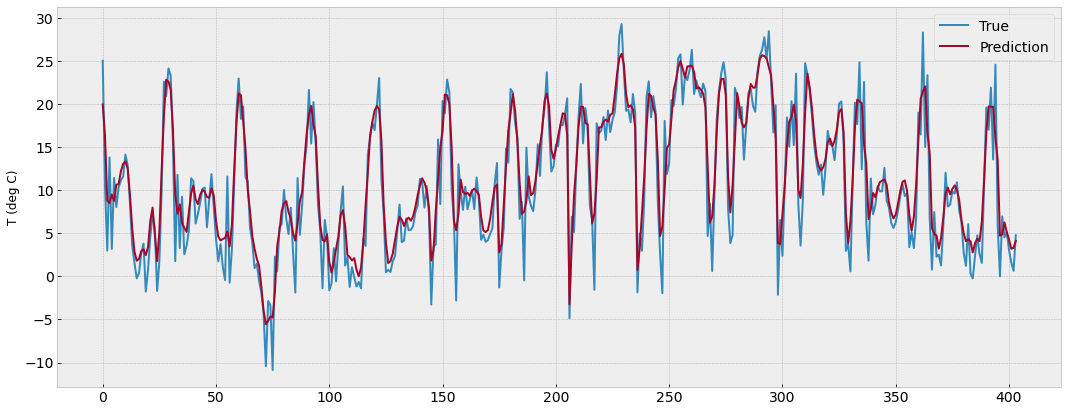

In [21]:
plot_test_predict(y, y_hat)

# Time series Transformer, basic implementation

In [22]:
class TSTransformerVanilla(pl.LightningModule):
    # d_model : number of features
    def __init__(self, feature_size=1, num_layers=3, num_heads=7,
                 dropout=0, learning_rate=1e-3, seq_len=8, criterion=nn.MSELoss()):
        super(TSTransformerVanilla, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size,
                                                        nhead=num_heads,
                                                        dropout=dropout,
                                                        batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.seq_len = seq_len
        self.decoder = self.create_decoder(feature_size * seq_len, dropout=dropout)
        self.learning_rate = learning_rate
        self.mask = self._generate_square_subsequent_mask(self.seq_len)
        self.init_weights()
        self.criterion = criterion
        self.val_mae = torchmetrics.MeanAbsoluteError()
        self.test_mae = torchmetrics.MeanAbsoluteError()

    def create_decoder(self, ndim, c_out=1, dropout=0):
        layers = [nn.Flatten()]
        if dropout:
            layers += [nn.Dropout(dropout)]
        layers += [nn.Linear(ndim, c_out)]
        return nn.Sequential(*layers)

    @torch.no_grad()
    def init_weights(self, initrange=1e-4):
        def _init(m):
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.normal_(m.bias, std=initrange)            
        self.apply(_init)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        assert src.shape[1] == self.seq_len, "incorrect sequence len"
        output = self.transformer_encoder(src, self.mask)
        output = self.decoder(output)
        return output

    def configure_optimizers(self):
        if self.mask.device != self.device:
            self.mask = self.mask.to(self.device)
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def training_epoch_end(self, outputs):
        # outputs is a list of dicts
        mean_loss = torch.stack([l['loss'] for l in outputs]).mean()
        self.log('train_loss', mean_loss, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.val_mae.update(y_hat, y)
        return loss

    def validation_epoch_end(self, outputs):
        # outputs is a list of step losses
        self.log('val_loss', torch.mean(torch.stack(outputs)), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.test_mae.update(y_hat, y)
        return loss
    
    def test_epoch_end(self, outputs):
        self.log('test_loss', np.mean(outputs))


In [23]:
tfr_param = dict(
                seq_len = 7,
                batch_size = 96,
                criterion = nn.MSELoss(),
                max_epochs = 50,
                num_heads = 4,
                n_features = 4,
                d_model = 4,
                num_layers = 4,
                dropout = 0.1,
                learning_rate = 1e-3,)
# assert state_tfr['n_features'] % 2 == 1, "n_features should be even"

In [24]:
seed_everything(1)
tfr_trainer = pl.Trainer(
    max_epochs=tfr_param['max_epochs'],
    gpus=gpus,
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[LitProgressBar()],
    log_every_n_steps=20,
    logger=CSVLogger('logs', name='transformer', version='vanilla')
    )

tfr_dm = SequenceDataModule(
    X_train,
    X_test,
    n_features = tfr_param['n_features'],
    seq_len = tfr_param['seq_len'],
    batch_size = tfr_param['batch_size'],
    )

Global seed set to 1
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


In [25]:
tfr_model = TSTransformerVanilla(feature_size=tfr_param['d_model'],
                                num_heads=tfr_param['num_heads'],
                                num_layers=tfr_param['num_layers'],
                                seq_len=tfr_param['seq_len'],
                                learning_rate=tfr_param['learning_rate'],
                                dropout=tfr_param['dropout'])

## Training

In [26]:
tfr_trainer.fit(
    tfr_model,
    datamodule=tfr_dm);



  | Name                | Type                    | Params
----------------------------------------------------------------
0 | encoder_layer       | TransformerEncoderLayer | 18.5 K
1 | transformer_encoder | TransformerEncoder      | 74.1 K
2 | decoder             | Sequential              | 29    
3 | criterion           | MSELoss                 | 0     
4 | val_mae             | MeanAbsoluteError       | 0     
5 | test_mae            | MeanAbsoluteError       | 0     
----------------------------------------------------------------
92.7 K    Trainable params
0         Non-trainable params
92.7 K    Total params
0.371     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

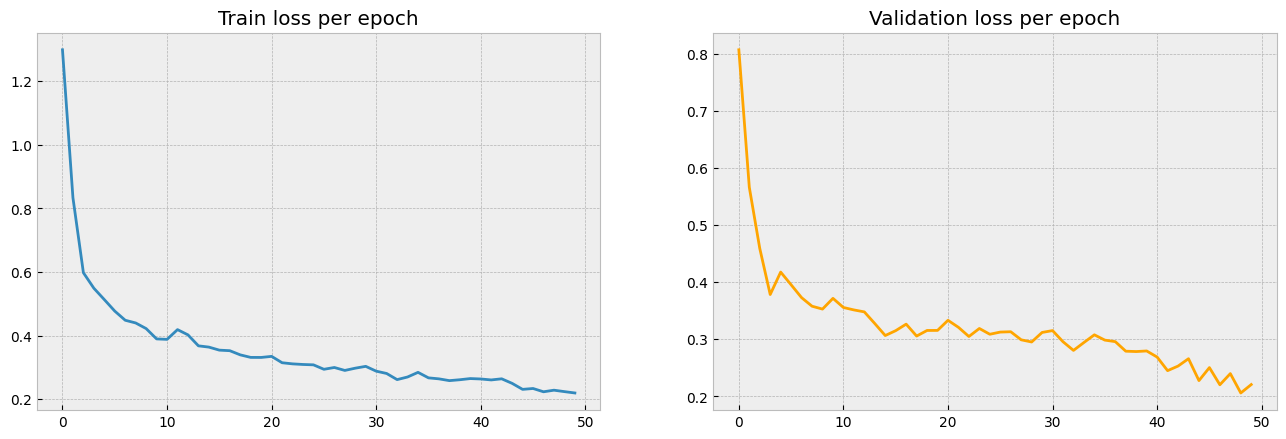

MSE:
	Train loss: 0.220
	Val loss:   0.221


In [27]:
plot_training_metrics(tfr_trainer.logger)

## Testing / Prediction

Predicting: 21it [00:00, ?it/s]

MAE loss (sklearn): 0.35
MSE loss (sklearn): 0.22


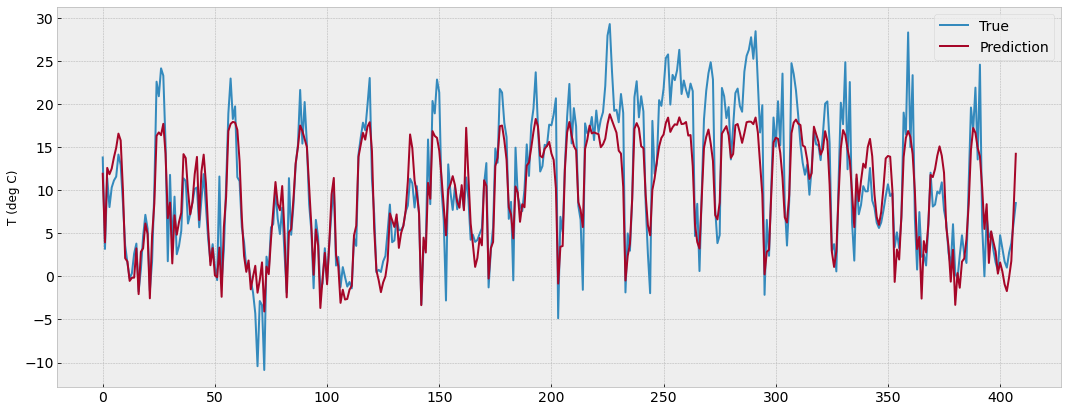

In [28]:
_, y = map(torch.cat, zip(*tfr_dm.test_dataloader()))
y_hat = torch.cat(tfr_trainer.predict(tfr_model, tfr_dm))
plot_test_predict(y, y_hat)

# Transformer + Positional Encoding

## Positional encoding (recap)

Reminder of positional encoding formula:
$$\overrightarrow{p_{t}}^{(i)}=f(t)^{(i)}:= \begin{cases}\sin \left(\omega_{k} \cdot t\right), & \text { if } i=2 k \\ \cos \left(\omega_{k} \cdot t\right), & \text { if } i=2 k+1\end{cases}$$

where

$$\omega_{k}=\frac{1}{10000^{2 k / d}}, k \in [0, d/2)$$

In [29]:
# Once given those parameters, one can construct a tensor with this encoding
seq_len = 32
d_model = 4

pe = torch.zeros(seq_len, d_model)  # positional encoding
position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
print("Debug, div_term", div_term)

Debug, div_term tensor([1.0000, 0.0100])


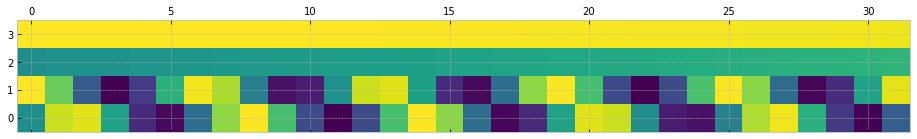

In [30]:
plt.matshow(pe.numpy().T, origin='lower');

## Task 1 (Score: 2)

Implement sincos inside PositionalEncoding method following the logic above 

In [31]:
def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3, verbose=False):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def PositionalEncoding(q_len, d_model, normalize=True): # TODO: define device
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)


    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe

class TSTransformerPositional(TSTransformerVanilla):
    # d_model : number of features
    def __init__(self, feature_size=1, num_layers=3, num_heads=7,
                 dropout=0, learning_rate=1e-3, seq_len=8, criterion=nn.MSELoss()):
        super(TSTransformerPositional, self).__init__(feature_size, num_layers, num_heads=num_heads,
                                                    dropout=dropout, learning_rate=learning_rate,
                                                    seq_len=seq_len, criterion=criterion)

        #self.W_pos = self._positional_encoding(None, True, seq_len, feature_size)
        #self.W_pos = self._positional_encoding("zeros", True, seq_len, feature_size)
        #self.W_pos = self._positional_encoding("normal", False, seq_len, feature_size)
        #self.W_pos = self._positional_encoding("uniform", True, seq_len, feature_size)
        #self.W_pos = nn.Parameter(self._positional_encoding("sincos", True, seq_len, feature_size, normalize=True))
        #self.W_pos = self._positional_encoding("lin2d", True, seq_len, feature_size,  normalize=True)
        self.W_pos = self._positional_encoding("exp2d", False, seq_len, feature_size,  normalize=False)
        # self.W_pos = self._positional_encoding("exp2d", False, seq_len, feature_size,  normalize=True)
        self.dropout = nn.Dropout(dropout)

    def _positional_encoding(self, pe, learn_pe, q_len=1, d_model=1, normalize=True):
        device = self.device
        if pe == None:
            W_pos = torch.zeros((q_len, d_model)) # pe = None and learn_pe = False can be used to measure impact of pe
            learn_pe = False
        elif pe == 'zeros':
            W_pos = torch.empty((q_len, d_model))
            nn.init.uniform_(W_pos, -0.02, 0.02)
        elif pe == 'normal' or pe == 'gauss':
            W_pos = torch.zeros((q_len, d_model))
            torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
        elif pe == 'uniform':
            W_pos = torch.zeros((q_len, d_model))
            nn.init.uniform_(W_pos, a=0.0, b=0.1)
        elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=normalize)
        elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=normalize)
        elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=normalize)
        return nn.Parameter(W_pos, requires_grad=learn_pe)

    def forward(self, src):
        assert src.shape[1] == self.seq_len, "incorrect sequence len"
        src = self.dropout(src + self.W_pos)

        output = self.transformer_encoder(src, self.mask)
        # output = output.transpose(2,1).contiguous()
        output = self.decoder(output)
        return output



In [32]:
seed_everything(1)
tfr_pos_trainer = pl.Trainer(
    max_epochs=tfr_param['max_epochs'],
    gpus=gpus,
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[LitProgressBar()], # early_stop_callback],
    log_every_n_steps = 20,
    logger=CSVLogger('logs', name='transformer', version='pos')
    )

tfr_pos_dm = SequenceDataModule(
    X_train,
    X_test,
    n_features = tfr_param['n_features'],
    seq_len = tfr_param['seq_len'],
    batch_size = tfr_param['batch_size'],
    )

Global seed set to 1
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


In [33]:
tfr_pos_model = TSTransformerPositional(feature_size=tfr_param['d_model'],
                                        num_heads=tfr_param['num_heads'],
                                        num_layers=tfr_param['num_layers'],
                                        seq_len=tfr_param['seq_len'],
                                        learning_rate=tfr_param['learning_rate'],
                                        dropout=tfr_param['dropout'])

## Training

In [34]:
tfr_pos_trainer.fit(
    tfr_pos_model,
    datamodule=tfr_pos_dm)


  | Name                | Type                    | Params
----------------------------------------------------------------
0 | encoder_layer       | TransformerEncoderLayer | 18.5 K
1 | transformer_encoder | TransformerEncoder      | 74.1 K
2 | decoder             | Sequential              | 29    
3 | criterion           | MSELoss                 | 0     
4 | val_mae             | MeanAbsoluteError       | 0     
5 | test_mae            | MeanAbsoluteError       | 0     
6 | dropout             | Dropout                 | 0     
----------------------------------------------------------------
92.7 K    Trainable params
28        Non-trainable params
92.7 K    Total params
0.371     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

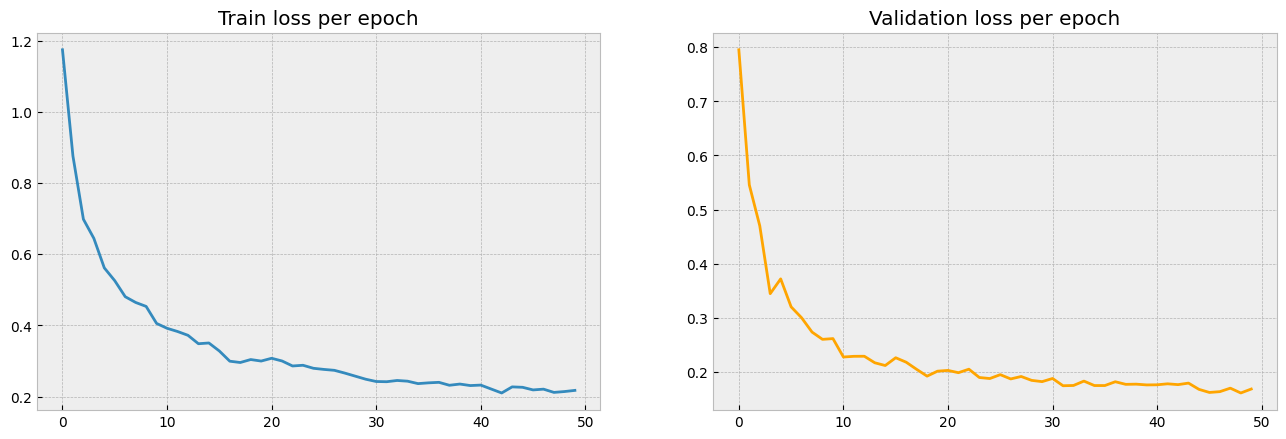

MSE:
	Train loss: 0.217
	Val loss:   0.168


In [35]:
plot_training_metrics(tfr_pos_trainer.logger)

## Testing / Prediction

Predicting: 21it [00:00, ?it/s]

MAE loss (sklearn): 0.30
MSE loss (sklearn): 0.15


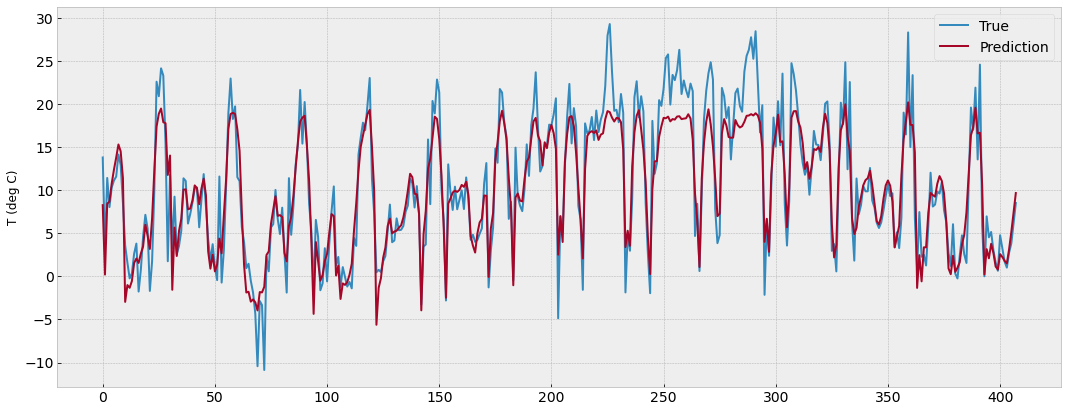

In [36]:
_, y = map(torch.cat, zip(*tfr_pos_dm.test_dataloader()))
y_hat = torch.cat(tfr_pos_trainer.predict(tfr_pos_model, tfr_pos_dm))
plot_test_predict(y, y_hat)

## Task 2 (Score: 2)

Compare various positional encodings implemented above. Play with 'normalization' and 'learning' parameters.

Make a table with the test performance under similar computational budget. 

In [37]:
print("None      Mae loss: 0.30   Mse loss: 0.16")
print("Zeros     Mae loss: 0.30   Mse loss: 0.16")
print("normal    Mae loss: 0.32   Mse loss: 0.18")
print("uniform   Mae loss: 0.31   Mse loss: 0.17")
print("sincos    Mae loss: 0.29   Mse loss: 0.15")
print("lin2d     Mae loss: 0.30   Mse loss: 0.16")
print("exp2d     Mae loss: 0.28   Mse loss: 0.14")

None      Mae loss: 0.30   Mse loss: 0.16
Zeros     Mae loss: 0.30   Mse loss: 0.16
normal    Mae loss: 0.32   Mse loss: 0.18
uniform   Mae loss: 0.31   Mse loss: 0.17
sincos    Mae loss: 0.29   Mse loss: 0.15
lin2d     Mae loss: 0.30   Mse loss: 0.16
exp2d     Mae loss: 0.28   Mse loss: 0.14


# Task 3 (Score: 2) TSTransformerPositionalCat

Implement `TSTransformerPositionalCat` so it concats positional encoding tensor to `src` instead of numerical adding. 

In [38]:
class TSTransformerPositionalCat(TSTransformerPositional):
    # d_model : number of features
    def __init__(self, feature_size=1, num_layers=3, num_heads=7,
                 dropout=0, learning_rate=1e-3, seq_len=8, criterion=nn.MSELoss()):
        # NB feature size is doubled since we send 2-times larger tensor to the encoder
        super(TSTransformerPositionalCat, self).__init__(feature_size * 2, num_layers, num_heads=num_heads,
                                                    dropout=dropout, learning_rate=learning_rate,
                                                    seq_len=seq_len, criterion=criterion)

        self.W_pos = self._positional_encoding("sincos", False, seq_len, feature_size, normalize=False)
    

    def forward(self, src):
        assert src.shape[1] == self.seq_len, "incorrect sequence len"
        src_pos = torch.zeros(src.shape[0],self.W_pos.shape[0],self.W_pos.shape[1]*2) 
        for i in range(src.shape[0]):
          src_pos[i] = torch.cat((src[i], self.W_pos),dim = 1)

        src = self.dropout(src_pos)

        output = self.transformer_encoder(src, self.mask)
        output = self.decoder(output)
        return output

In [39]:
seed_everything(1)
tfr_pos_cat_trainer = pl.Trainer(
    max_epochs=tfr_param['max_epochs'],
    gpus=gpus,
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[LitProgressBar()], # early_stop_callback],
    log_every_n_steps=20,
    logger=CSVLogger('logs', name='transformer', version='pos-cat')
    )

tfr_pos_cat_dm = SequenceDataModule(
    X_train,
    X_test,
    n_features = tfr_param['n_features'],
    seq_len = tfr_param['seq_len'],
    batch_size = tfr_param['batch_size'],
    )

Global seed set to 1
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


In [40]:
tfr_pos_cat_model = TSTransformerPositionalCat(
    feature_size=tfr_param['d_model'],
    num_heads=tfr_param['num_heads'],
    num_layers=tfr_param['num_layers'],
    seq_len=tfr_param['seq_len'],
    learning_rate=tfr_param['learning_rate'],
    dropout=tfr_param['dropout']
)

## Train

In [41]:
tfr_pos_cat_trainer.fit(
    tfr_pos_cat_model,
    datamodule=tfr_pos_cat_dm)


  | Name                | Type                    | Params
----------------------------------------------------------------
0 | encoder_layer       | TransformerEncoderLayer | 35.1 K
1 | transformer_encoder | TransformerEncoder      | 140 K 
2 | decoder             | Sequential              | 57    
3 | criterion           | MSELoss                 | 0     
4 | val_mae             | MeanAbsoluteError       | 0     
5 | test_mae            | MeanAbsoluteError       | 0     
6 | dropout             | Dropout                 | 0     
----------------------------------------------------------------
175 K     Trainable params
28        Non-trainable params
175 K     Total params
0.703     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

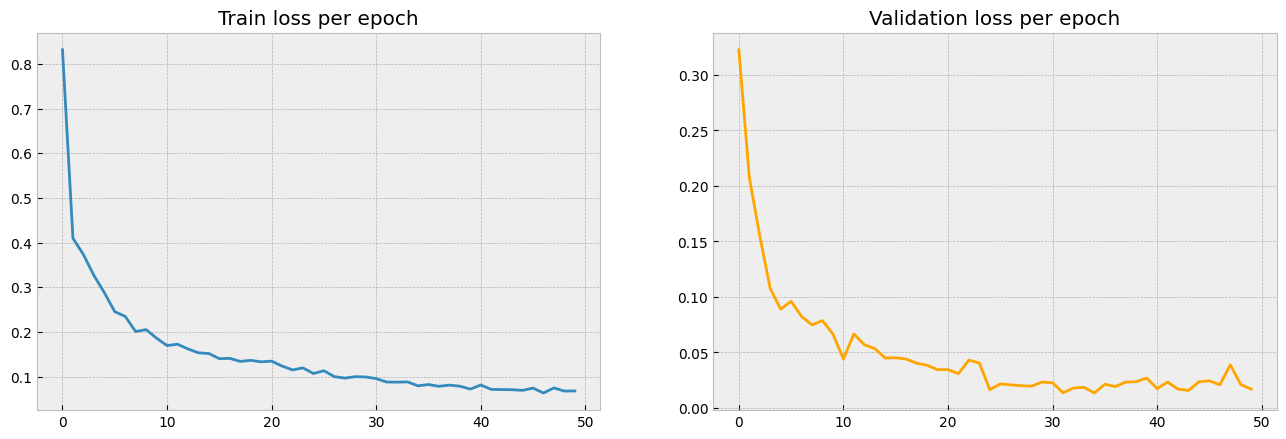

MSE:
	Train loss: 0.068
	Val loss:   0.017


In [42]:
plot_training_metrics(tfr_pos_cat_trainer.logger)

## Testing / Prediction

Predicting: 21it [00:00, ?it/s]

MAE loss (sklearn): 0.09
MSE loss (sklearn): 0.01


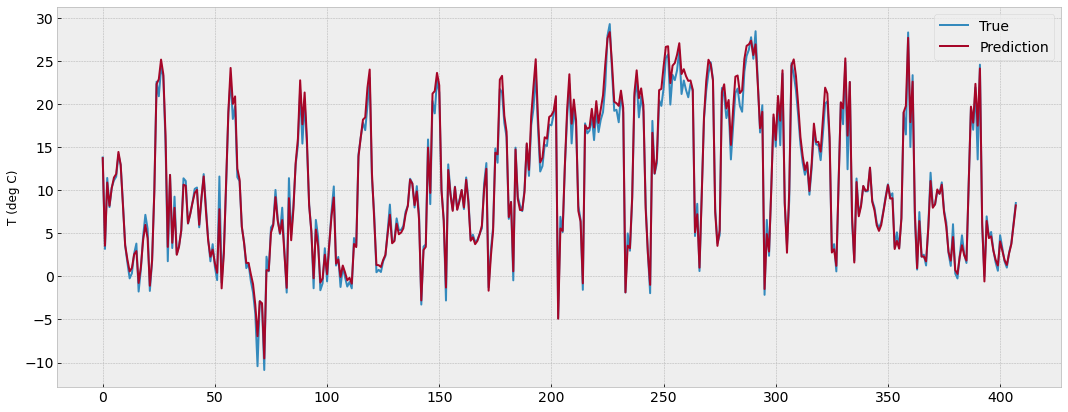

In [43]:
_, y = map(torch.cat, zip(*tfr_pos_cat_dm.test_dataloader()))
y_hat = torch.cat(tfr_pos_cat_trainer.predict(tfr_pos_cat_model, tfr_pos_cat_dm))
plot_test_predict(y, y_hat)

# Conclusion

This notebook taught us the basic use of transformers applied to time-series data on a simple univariate example. For a more advanced implementation, please refer to packages intentionally designed for such data crunching, e.g.:
- https://github.com/timeseriesAI/tsai/
- https://github.com/jdb78/pytorch-forecasting